In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

from urllib.request import urlopen
from unidecode import unidecode

import pandas as pd
import numpy as np
import itertools
import sys
import re
import os

import pymmwr as pm
import urllib

sys.path.insert(0, "..")
from global_config import config

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')

plt.rc('font', size=15)

In [2]:
data_df                    = pd.read_csv(os.path.join(data_dir, "processed_data_us.csv"), parse_dates=["date"])
data_df["total_sqrt"]      = np.sqrt(data_df["total"])
data_df["total_sqrt_norm"] = (data_df["total_sqrt"]-data_df["total_sqrt"].mean()) / data_df["total_sqrt"].std()

p = np.polyfit(data_df.index.values, data_df["total"], 1)

dat_notrend = data_df["total"] - np.polyval(p, data_df.index.values)
std         = dat_notrend.std()  # Standard deviation
var         = std ** 2  # Variance
dat_norm    = dat_notrend / std  # Normalized dataset

data_df["total_detrend"] = dat_norm

In [3]:
from pycwt.helpers import find
import pycwt as wavelet


dt = 1/12; dj = 1/30; pad = 256; stype = 3/12; wtype = 6; par = 0;

dat      = data_df["total_detrend"].values
std      = np.std(data_df["total_detrend"])

mother      = wavelet.Morlet(6)
s0          = stype   # Starting scale, in this case 2 * 0.25 years = 6 months
dj          = 1 / 12  # Twelve sub-octaves per octaves
J           = 3 / dj   # Seven powers of two with dj sub-octaves
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise
dat_norm    = data_df["total_detrend"].values;   # totalkok
# The following routines perform the wavelet transform and inverse wavelet
# transform using the parameters defined above. Since we have normalized our
# input time-series, we multiply the inverse transform by the standard
# deviation.
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J,
                                                      mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

# We calculate the normalized wavelet and Fourier power spectra, as well as
# the Fourier equivalent periods for each wavelet scale.
power     = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period    = 1 / freqs


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


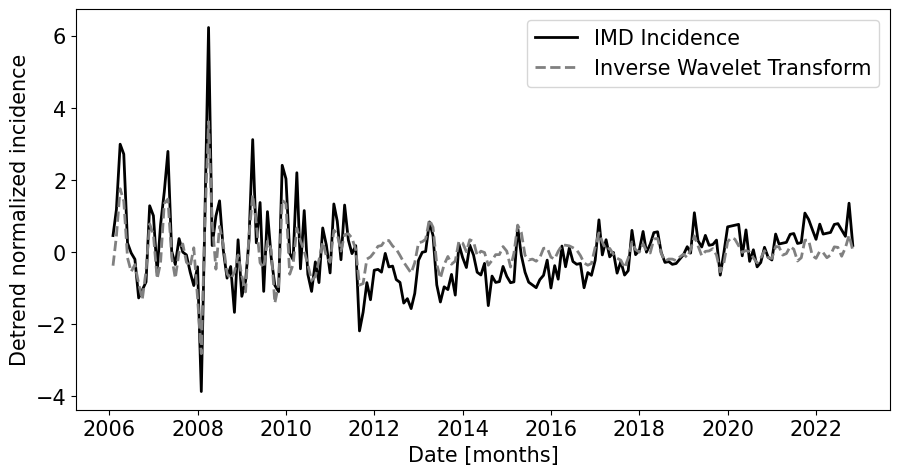

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10.5, 5.2))
ax.plot(data_df.date, dat, 'k',  lw=2,  label="IMD Incidence")
ax.plot(data_df.date, iwave, ls='--', color=[0.5, 0.5, 0.5], lw=2, label="Inverse Wavelet Transform")
ax.set_xlabel("Date [months]")
ax.set_ylabel("Detrend normalized incidence")
ax.legend(loc="upper right")


In [5]:
# We could stop at this point and plot our results. However we are also
# interested in the power spectra significance test. The power is significant
# where the ratio ``power / sig95 > 1``.
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)

N     = len(data_df)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

# Then, we calculate the global wavelet spectrum and determine its
# significance level.
glbl_power       = power.mean(axis=1)
dof              = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                        significance_level=0.95, dof=dof,
                                        wavelet=mother)

# We also calculate the scale average between 2 years and 8 years, and its
# significance level.
sel                   = find((period >= 2) & (period < 8))
Cdelta                = mother.cdelta
scale_avg             = (scales * np.ones((N, 1))).transpose()
scale_avg             = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg             = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                             significance_level=0.95,
                                             dof=[scales[sel[0]],
                                                  scales[sel[-1]]],
                                             wavelet=mother)


Text(0.5, 0, 'Year')

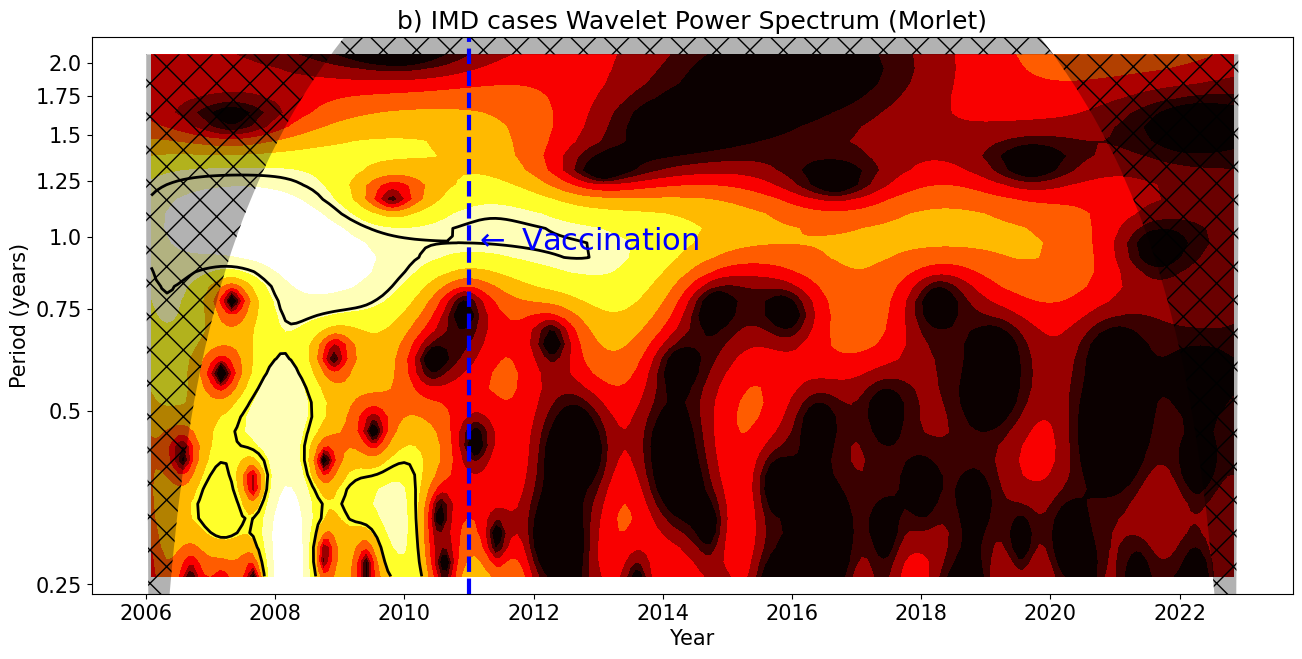

In [6]:
import datetime

fig, bx = plt.subplots(1, 1, figsize=(15.5, 7.23))
# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
#bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
bx.contourf(data_df.date, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.hot)
extent = [data_df.date.min(), data_df.date.max(), 0, max(period)]
bx.contour(data_df.date, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)

y_lim_countour =  bx.get_ylim()

data_df.date = data_df.date
dt_date = datetime.timedelta(weeks=4)
bx.fill(np.concatenate([data_df.date, data_df.date[-1:] + dt_date, data_df.date[-1:] + dt_date,
                           data_df.date[:1] - dt_date, data_df.date[:1] - dt_date]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format("IMD cases", mother.name))
bx.set_ylabel('Period (years)')

Yticks = 2 ** np.log2(np.arange(stype, 4+ stype, stype))


bx.text(x=pd.to_datetime("2011-02"), y=np.log2(0.95), s=r"$\leftarrow$ Vaccination", color="blue", fontsize=22)
bx.axvline(x=pd.to_datetime("2011"), color="blue", ls="--", lw=3)


bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)
bx.set_ylim(np.array(y_lim_countour) - (0.1, -0.1))
bx.set_xlabel("Year")


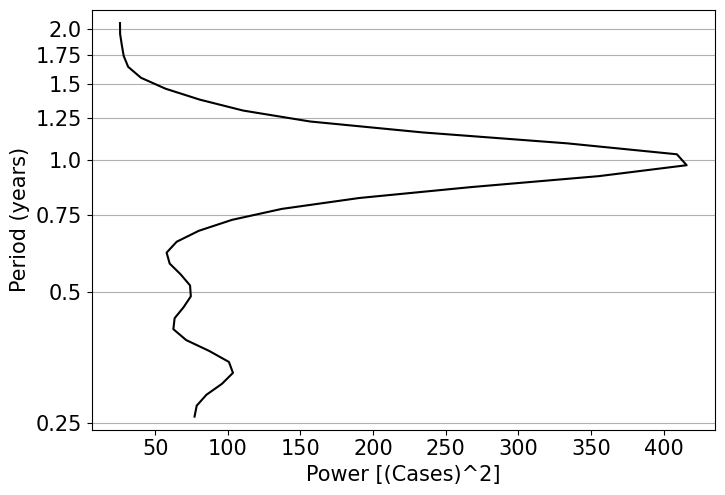

In [7]:
fig, cx = plt.subplots(1, 1, figsize=(7.5, 5.2))
#cx.plot(glbl_signif, np.log2(period), 'k--', lw=2)
#cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)

cx.set_ylim(np.array(y_lim_countour) - (0.1, -0.1))
cx.set_xlabel(r'Power [({})^2]'.format("Cases"))
cx.set_ylabel("Period (years)")
cx.grid(axis="y")
plt.tight_layout()

/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


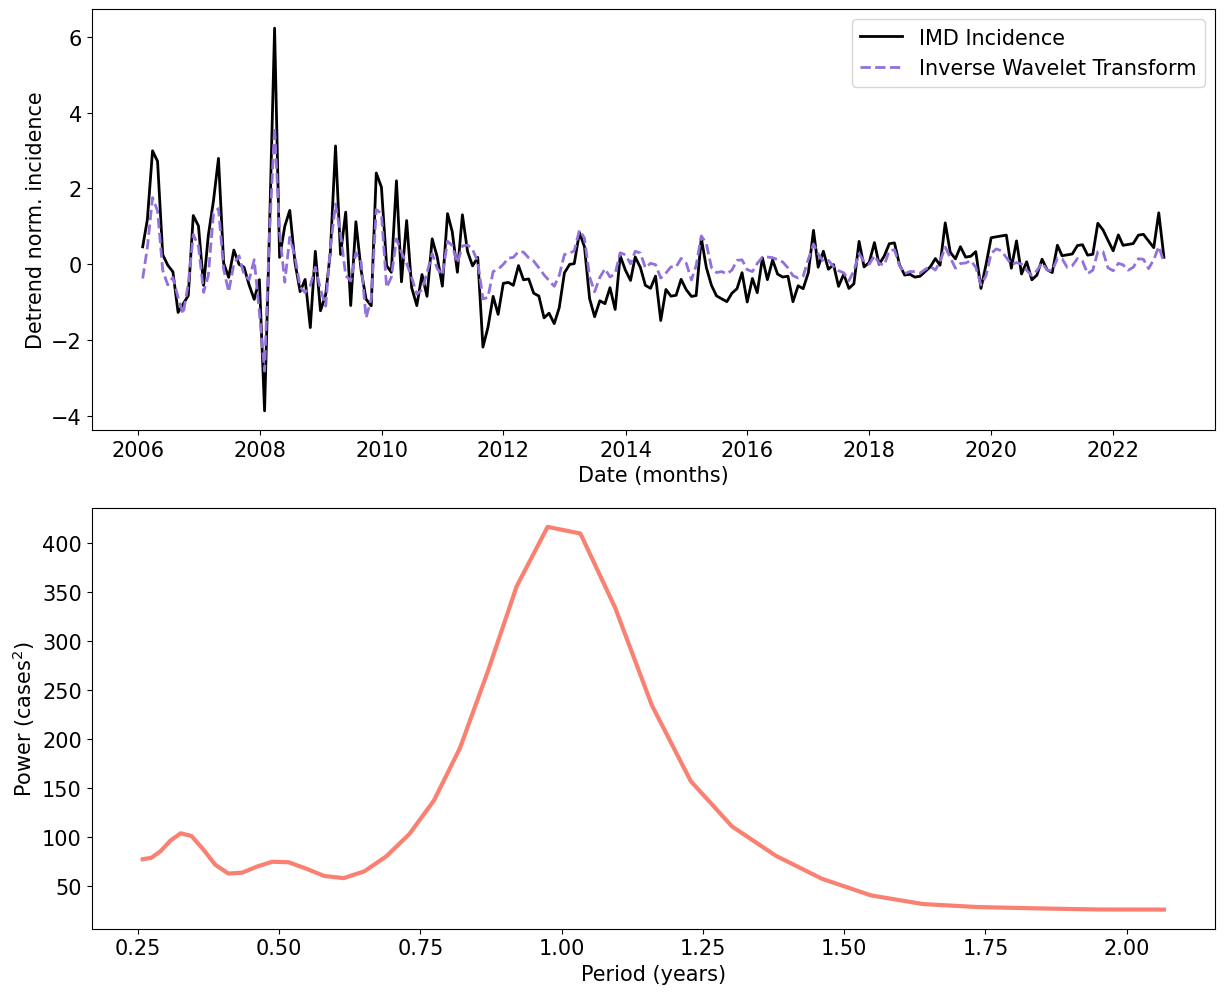

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12.5, 10.2))
ax[0].plot(data_df.date, dat, 'k',  lw=2,  label="IMD Incidence")
ax[0].plot(data_df.date, iwave, ls='--', color="mediumpurple", lw=2, label="Inverse Wavelet Transform")
ax[0].set_xlabel("Date (months)")
ax[0].set_ylabel("Detrend norm. incidence")
ax[0].legend(loc="upper right")

ax[1].plot(period, var * glbl_power, ls='-', color="salmon", linewidth=3)
ax[1].set_ylabel(r"Power (cases$^2$)")
ax[1].set_xlabel("Period (years)")
plt.tight_layout()

#fig.savefig(os.path.join(results_dir, "figures", "IMD_IWT_power_cases.png"), dpi=300, transparent=True)


In [9]:
period_analysis_df = pd.DataFrame( columns=["period", "power"])
period_analysis_df["period"] = period
period_analysis_df["power"]  = power
period_analysis_df.to_csv(os.path.join(data_dir, "period_power.csv"), index=False)


In [10]:
def format_axis(ax, week=True):
    ax.tick_params(which='both', axis='x', labelrotation=90)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    if week:
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [11]:
# Plot Tong's default setting
SMALL_SIZE  = 28
MEDIUM_SIZE = 28
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels"
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text')

/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


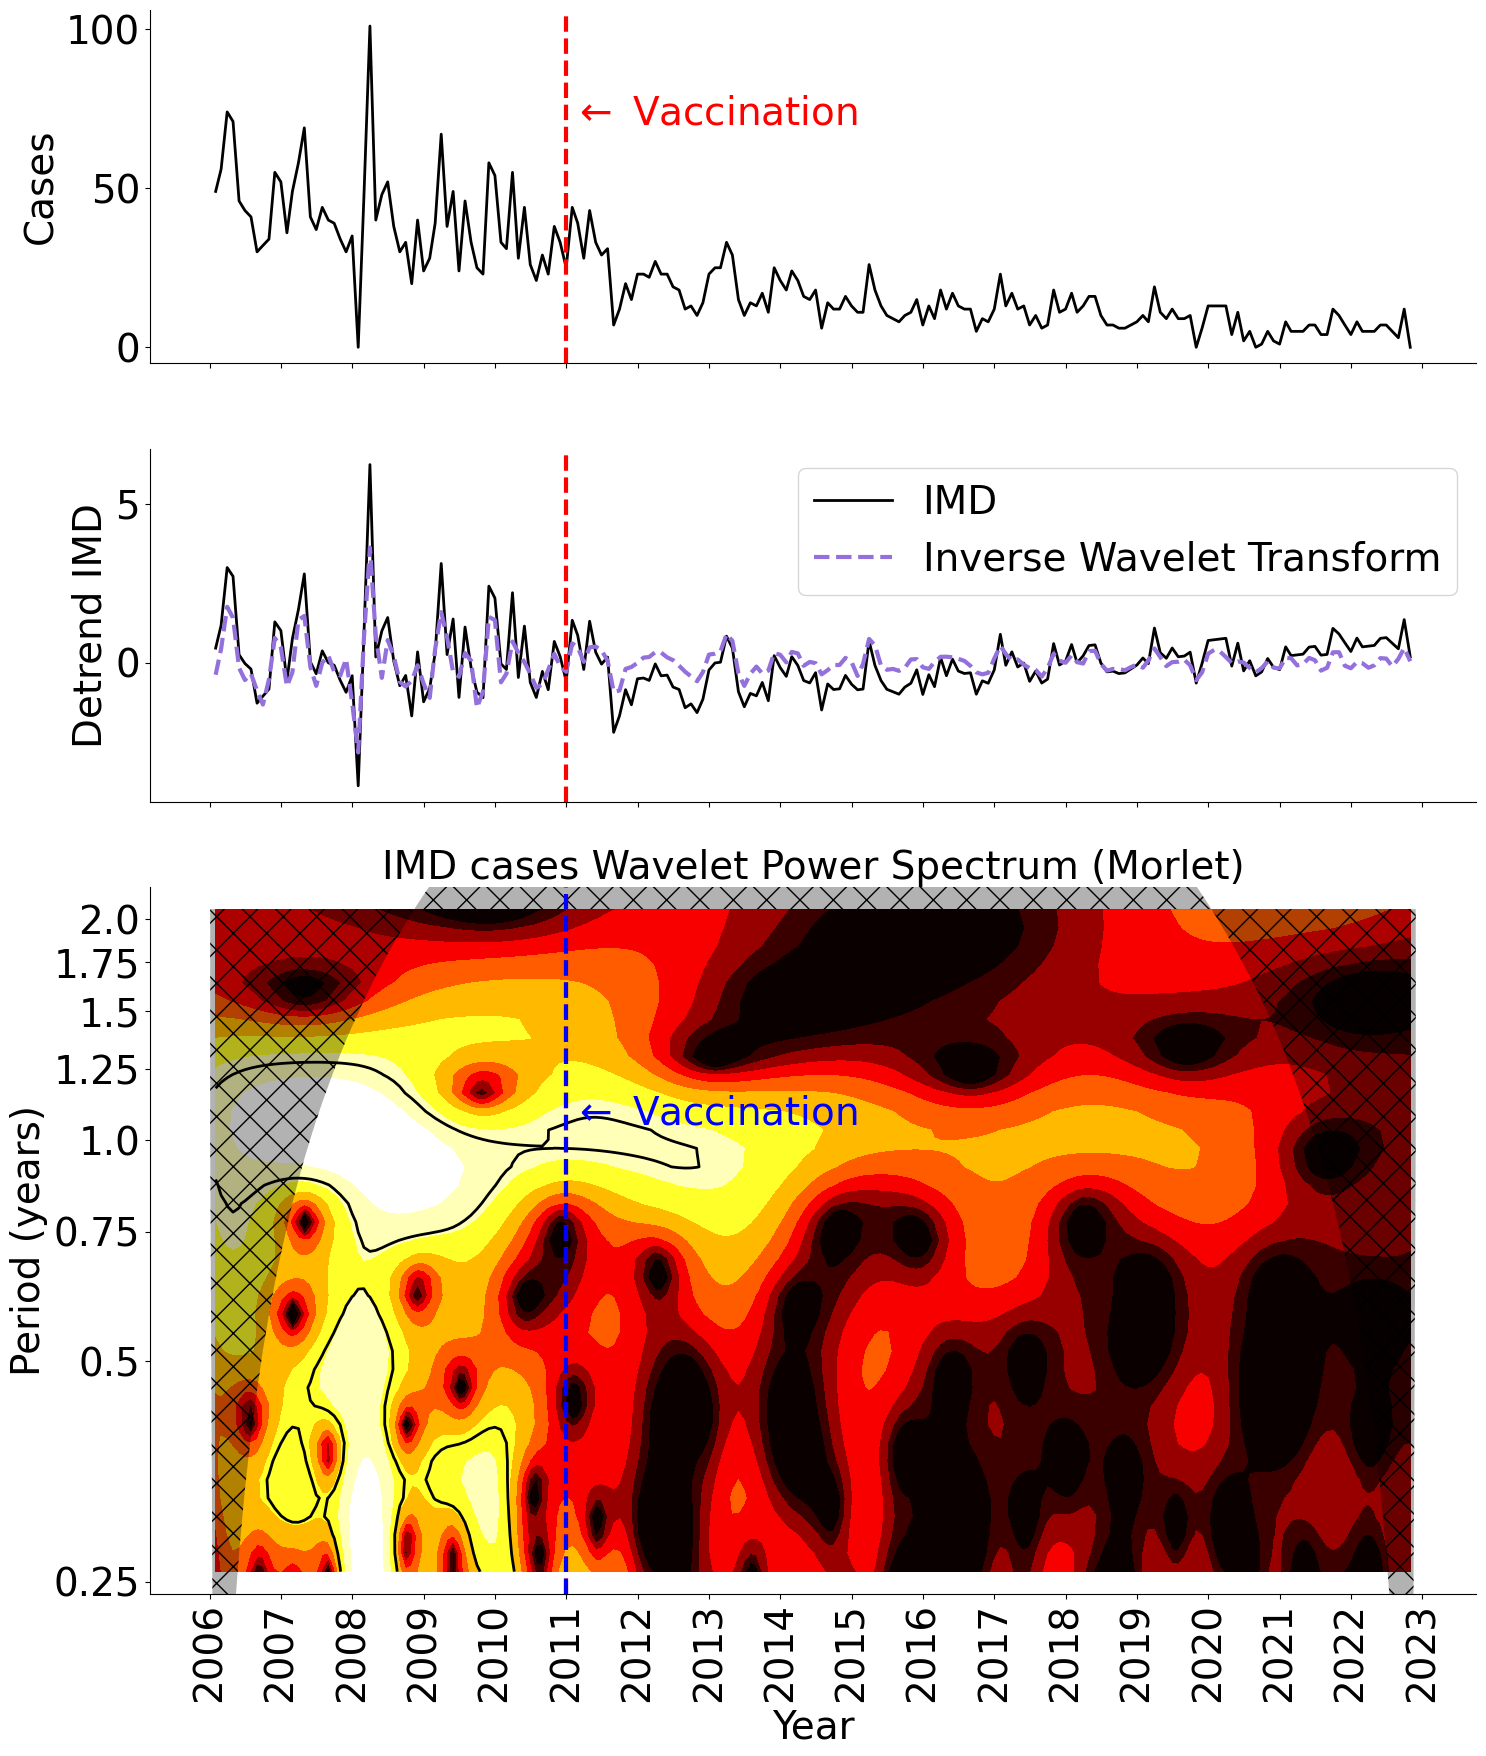

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(15.5, 18.2), sharex=True, gridspec_kw={'height_ratios': [1, 1, 2]})

ax[0].plot(data_df.date, data_df.total, color="k", lw=2)
ax[0].set_ylabel("Cases")


ax[1].plot(data_df.date, dat, 'k',  lw=2,  label="IMD")
ax[1].plot(data_df.date, iwave, ls='--', color="mediumpurple", lw=3, label="Inverse Wavelet Transform")
ax[1].set_ylabel("Detrend IMD")
ax[1].legend(loc="upper right")

pos = [70,  50 / std]

for axi in ax.flatten():
    format_axis(axi, week=False)
    axi.axvline(x=pd.to_datetime("2011"), lw=3, color="r", ls="--")
ax[0].text(x=pd.to_datetime("2011-02"), y=pos[0], s=r"$\leftarrow$ Vaccination", color="red")

###### PLOT power spectrum ######
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
ax[2].contourf(data_df.date, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.hot)
extent = [data_df.date.min(), data_df.date.max(), 0, max(period)]
ax[2].contour(data_df.date, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)

y_lim_countour =  ax[2].get_ylim()

dt_date = datetime.timedelta(weeks=4)
ax[2].fill(np.concatenate([data_df.date, data_df.date[-1:] + dt_date, data_df.date[-1:] + dt_date,
                           data_df.date[:1] - dt_date, data_df.date[:1] - dt_date]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
ax[2].set_title('{} Wavelet Power Spectrum ({})'.format("IMD cases", mother.name))
ax[2].set_ylabel('Period (years)')

Yticks = 2 ** np.log2(np.arange(stype, 4+ stype, stype))

ylim_j = np.array([-2.05309879,  1.14690121])

ax[2].text(x=pd.to_datetime("2011-02"), y=np.log2(1.05), s=r"$\leftarrow$ Vaccination", color="blue")
ax[2].axvline(x=pd.to_datetime("2011"), color="blue", ls="--", lw=3)
ax[2].set_yticks(np.log2(Yticks))
ax[2].set_yticklabels(Yticks)
ax[2].set_xlabel("Year")
ax[2].set_ylim(ylim_j) #np.array(y_lim_countour) - (0.1, -0.1))

plt.tight_layout()
fig.savefig(os.path.join(results_dir, "figures", "paper_figs", "Figure2.png"), dpi=300, transparent=True)


In [14]:
# show power sliced at maximum period decreasing in time - probably an effect of vaccination.

In [23]:
period

array([0.25826091, 0.2736179 , 0.28988807, 0.30712571, 0.32538836,
       0.34473696, 0.36523608, 0.38695415, 0.40996364, 0.43434135,
       0.46016863, 0.48753168, 0.51652182, 0.54723581, 0.57977614,
       0.61425143, 0.65077672, 0.68947392, 0.73047217, 0.7739083 ,
       0.81992729, 0.8686827 , 0.92033726, 0.97506336, 1.03304365,
       1.09447162, 1.15955229, 1.22850286, 1.30155344, 1.37894783,
       1.46094434, 1.54781661, 1.63985457, 1.7373654 , 1.84067452,
       1.95012673, 2.0660873 ])

In [30]:
var

101.04354172302256

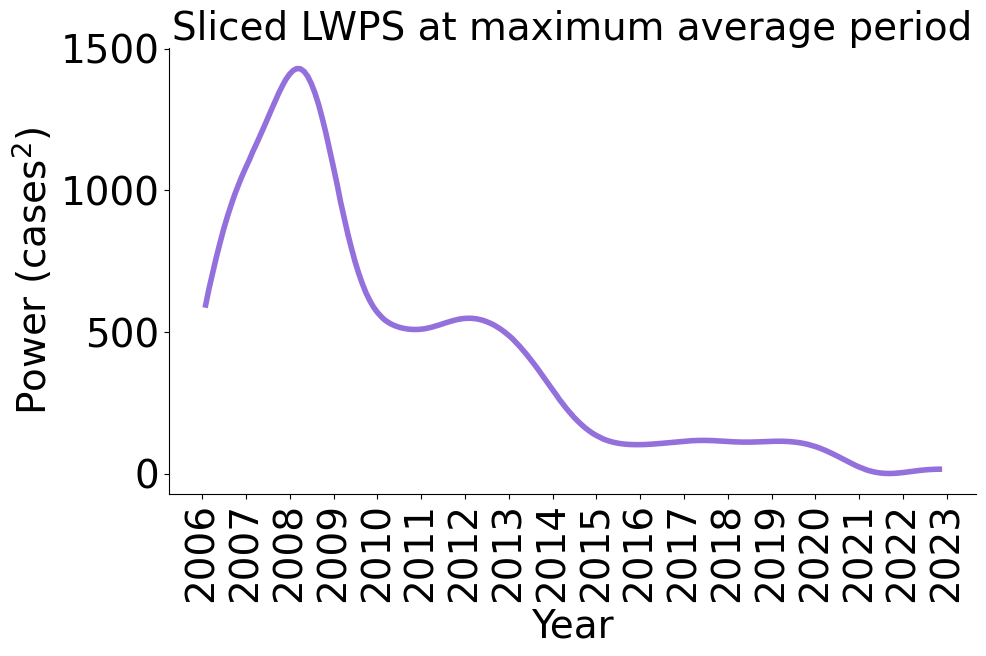

In [39]:
time_power = power[np.argmax( var * glbl_power), :]

fig, ax = plt.subplots(1, 1, figsize=(10.5, 7.2))
ax.plot(data_df.date, var * time_power, color="mediumpurple", label=period, lw=4)
ax.set_ylabel("Power (cases$^2$)")
ax.set_xlabel("Year")

format_axis(ax, week=False)
ax.set_title("Sliced LWPS at maximum average period")

plt.tight_layout()